In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install opendatasets

In [ ]:
import opendatasets as od
od.download("https://www.kaggle.com/datasets/mantasu/face-attributes-grouped")


Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: chathui3628
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/mantasu/face-attributes-grouped


100%|██████████| 1.50G/1.50G [00:15<00:00, 102MB/s]


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from PIL import Image

In [ ]:
# 1. CONFIGURATION
BASE_DIR = '/content/face-attributes-grouped/face-attributes-grouped'  # change if needed
TRAIN_DIR = os.path.join(BASE_DIR, 'train')
VAL_DIR   = os.path.join(BASE_DIR, 'val')
TEST_DIR  = os.path.join(BASE_DIR, 'test')

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS_HEAD = 25
EPOCHS_FINE = 75

# Only train 'facewear_model' category
CATEGORY = "facewear"
CLASSES = ['covered', 'fullmask', 'mouthmask', 'no_facewear']

In [ ]:
# 2. Data generators
datagen_train = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
datagen_val = ImageDataGenerator(rescale=1./255)

train_gen = datagen_train.flow_from_directory(
    os.path.join(TRAIN_DIR, CATEGORY),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    classes=CLASSES,
    class_mode='categorical',
    shuffle=True
)
val_gen = datagen_val.flow_from_directory(
    os.path.join(VAL_DIR, CATEGORY),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    classes=CLASSES,
    class_mode='categorical',
    shuffle=False
)
test_gen = datagen_val.flow_from_directory(
    os.path.join(TEST_DIR, CATEGORY),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    classes=CLASSES,
    class_mode='categorical',
    shuffle=False
)

Found 4000 images belonging to 4 classes.
Found 400 images belonging to 4 classes.
Found 400 images belonging to 4 classes.


In [ ]:
# 3. Build model
def build_model(num_classes, input_shape=(224,224,3)):
    base = Xception(weights='imagenet', include_top=False, input_shape=input_shape)
    x = GlobalAveragePooling2D()(base.output)
    x = Dropout(0.5)(x)
    out = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base.input, outputs=out)
    return model

model = build_model(num_classes=len(CLASSES), input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))


83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [12]:
# Phase 1: train head only
for layer in model.layers:
    if hasattr(layer, 'trainable'):
        layer.trainable = False
model.layers[-1].trainable = True  # only final Dense

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

cb1 = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),
    ModelCheckpoint(f'best_{CATEGORY}_phase1.h5', monitor='val_loss', save_best_only=True, verbose=1)
]

history1 = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS_HEAD,
    callbacks=cb1
)

# Phase 2: fine-tune top layers
model.load_weights(f'best_{CATEGORY}_phase1.h5')
for layer in model.layers:
    layer.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

cb2 = [
    EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, verbose=1),
    ModelCheckpoint(f'best_{CATEGORY}_final.h5', monitor='val_loss', save_best_only=True, verbose=1)
]

history2 = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS_FINE,
    callbacks=cb2
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.5928 - loss: 0.9528
Epoch 1: val_loss improved from inf to 0.50598, saving model to best_facewear_phase1.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 99s 609ms/step - accuracy: 0.5937 - loss: 0.9512 - val_accuracy: 0.8250 - val_loss: 0.5060 - learning_rate: 0.0010
Epoch 2/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step - accuracy: 0.7996 - loss: 0.5461
Epoch 2: val_loss improved from 0.50598 to 0.47621, saving model to best_facewear_phase1.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 59s 473ms/step - accuracy: 0.7997 - loss: 0.5461 - val_accuracy: 0.8325 - val_loss: 0.4762 - learning_rate: 0.0010
Epoch 3/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step - accuracy: 0.8028 - loss: 0.5128
Epoch 3: val_loss improved from 0.47621 to 0.45099, saving model to best_facewear_phase1.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 59s 466ms/step - accuracy: 0.8029 - loss: 0.5127 - val_accuracy: 0.8425 - val_loss: 0.4510 - learning_rate: 0.0010
Epoch 4/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step - accuracy: 0.8271 - loss: 0.4779
Epoch 4: val_loss improved from 0.45099 to 0.44024, saving model to best_facewear_phase1.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 58s 467ms/step - accuracy: 0.8271 - loss: 0.4780 - val_accuracy: 0.8400 - val_loss: 0.4402 - learning_rate: 0.0010
Epoch 5/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step - accuracy: 0.8290 - loss: 0.4678
Epoch 5: val_loss did not improve from 0.44024
125/125 ━━━━━━━━━━━━━━━━━━━━ 60s 480ms/step - accuracy: 0.8291 - loss: 0.4676 - val_accuracy: 0.8325 - val_loss: 0.4501 - learning_rate: 0.0010
Epoch 6/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step - accuracy: 0.8337 - loss: 0.4648
Epoch 6: val_loss did not improve from 0.44024
125/125 ━━━━━━━━━━━━━━━━━━━━ 59s 468ms/step - accuracy: 0.8338 - loss: 0.4648 - val_accuracy: 0.8350 - val_loss: 0.4425 - learning_rate: 0.0010
Epoch 7/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step - accuracy: 0.8439 - loss: 0.4347
Epoch 7: val_loss improved from 0.44024 to 0.42465, saving model to best_facewear_phase1.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 60s 483ms/step - accuracy: 0.8439 - loss: 0.4348 - val_accuracy: 0.8500 - val_loss: 0.4246 - learning_rate: 0.0010
Epoch 8/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step - accuracy: 0.8583 - loss: 0.4136
Epoch 8: val_loss did not improve from 0.42465
125/125 ━━━━━━━━━━━━━━━━━━━━ 58s 464ms/step - accuracy: 0.8582 - loss: 0.4138 - val_accuracy: 0.8450 - val_loss: 0.4293 - learning_rate: 0.0010
Epoch 9/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step - accuracy: 0.8450 - loss: 0.4254
Epoch 9: val_loss did not improve from 0.42465
125/125 ━━━━━━━━━━━━━━━━━━━━ 58s 464ms/step - accuracy: 0.8450 - loss: 0.4254 - val_accuracy: 0.8675 - val_loss: 0.4267 - learning_rate: 0.0010
Epoch 10/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step - accuracy: 0.8559 - loss: 0.3881
Epoch 10: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 10: val_loss did not improve from 0.42465
125/125 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.8558 - loss: 0.3883 - val

125/125 ━━━━━━━━━━━━━━━━━━━━ 140s 702ms/step - accuracy: 0.6927 - loss: 0.8110 - val_accuracy: 0.8625 - val_loss: 0.4361 - learning_rate: 1.0000e-05
Epoch 2/75
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 586ms/step - accuracy: 0.8291 - loss: 0.4661
Epoch 2: val_loss improved from 0.43614 to 0.39566, saving model to best_facewear_final.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 77s 618ms/step - accuracy: 0.8292 - loss: 0.4660 - val_accuracy: 0.8700 - val_loss: 0.3957 - learning_rate: 1.0000e-05
Epoch 3/75
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 578ms/step - accuracy: 0.8698 - loss: 0.3730
Epoch 3: val_loss improved from 0.39566 to 0.36077, saving model to best_facewear_final.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 75s 601ms/step - accuracy: 0.8698 - loss: 0.3730 - val_accuracy: 0.8800 - val_loss: 0.3608 - learning_rate: 1.0000e-05
Epoch 4/75
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 581ms/step - accuracy: 0.8871 - loss: 0.3202
Epoch 4: val_loss improved from 0.36077 to 0.33851, saving model to best_facewear_final.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 76s 603ms/step - accuracy: 0.8870 - loss: 0.3203 - val_accuracy: 0.8875 - val_loss: 0.3385 - learning_rate: 1.0000e-05
Epoch 5/75
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 580ms/step - accuracy: 0.8944 - loss: 0.2944
Epoch 5: val_loss improved from 0.33851 to 0.32041, saving model to best_facewear_final.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 81s 643ms/step - accuracy: 0.8944 - loss: 0.2944 - val_accuracy: 0.8900 - val_loss: 0.3204 - learning_rate: 1.0000e-05
Epoch 6/75
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 583ms/step - accuracy: 0.9036 - loss: 0.2922
Epoch 6: val_loss improved from 0.32041 to 0.30201, saving model to best_facewear_final.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 77s 615ms/step - accuracy: 0.9037 - loss: 0.2920 - val_accuracy: 0.8925 - val_loss: 0.3020 - learning_rate: 1.0000e-05
Epoch 7/75
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 581ms/step - accuracy: 0.9063 - loss: 0.2701
Epoch 7: val_loss improved from 0.30201 to 0.28718, saving model to best_facewear_final.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 76s 604ms/step - accuracy: 0.9063 - loss: 0.2700 - val_accuracy: 0.8925 - val_loss: 0.2872 - learning_rate: 1.0000e-05
Epoch 8/75
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 578ms/step - accuracy: 0.9133 - loss: 0.2347
Epoch 8: val_loss improved from 0.28718 to 0.28108, saving model to best_facewear_final.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 75s 600ms/step - accuracy: 0.9133 - loss: 0.2347 - val_accuracy: 0.9000 - val_loss: 0.2811 - learning_rate: 1.0000e-05
Epoch 9/75
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 583ms/step - accuracy: 0.9255 - loss: 0.2090
Epoch 9: val_loss improved from 0.28108 to 0.27484, saving model to best_facewear_final.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 83s 606ms/step - accuracy: 0.9255 - loss: 0.2091 - val_accuracy: 0.8950 - val_loss: 0.2748 - learning_rate: 1.0000e-05
Epoch 10/75
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 575ms/step - accuracy: 0.9286 - loss: 0.2126
Epoch 10: val_loss improved from 0.27484 to 0.27015, saving model to best_facewear_final.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 80s 640ms/step - accuracy: 0.9286 - loss: 0.2126 - val_accuracy: 0.9000 - val_loss: 0.2702 - learning_rate: 1.0000e-05
Epoch 11/75
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 574ms/step - accuracy: 0.9379 - loss: 0.1735
Epoch 11: val_loss improved from 0.27015 to 0.26583, saving model to best_facewear_final.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 78s 620ms/step - accuracy: 0.9379 - loss: 0.1735 - val_accuracy: 0.8975 - val_loss: 0.2658 - learning_rate: 1.0000e-05
Epoch 12/75
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 582ms/step - accuracy: 0.9420 - loss: 0.1707
Epoch 12: val_loss improved from 0.26583 to 0.26079, saving model to best_facewear_final.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 77s 613ms/step - accuracy: 0.9420 - loss: 0.1707 - val_accuracy: 0.8950 - val_loss: 0.2608 - learning_rate: 1.0000e-05
Epoch 13/75
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 589ms/step - accuracy: 0.9418 - loss: 0.1619
Epoch 13: val_loss improved from 0.26079 to 0.25582, saving model to best_facewear_final.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 78s 622ms/step - accuracy: 0.9418 - loss: 0.1619 - val_accuracy: 0.8925 - val_loss: 0.2558 - learning_rate: 1.0000e-05
Epoch 14/75
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 583ms/step - accuracy: 0.9497 - loss: 0.1378
Epoch 14: val_loss improved from 0.25582 to 0.25123, saving model to best_facewear_final.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 81s 643ms/step - accuracy: 0.9497 - loss: 0.1378 - val_accuracy: 0.8975 - val_loss: 0.2512 - learning_rate: 1.0000e-05
Epoch 15/75
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 589ms/step - accuracy: 0.9546 - loss: 0.1385
Epoch 15: val_loss did not improve from 0.25123
125/125 ━━━━━━━━━━━━━━━━━━━━ 76s 603ms/step - accuracy: 0.9546 - loss: 0.1386 - val_accuracy: 0.9025 - val_loss: 0.2536 - learning_rate: 1.0000e-05
Epoch 16/75
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 580ms/step - accuracy: 0.9544 - loss: 0.1337
Epoch 16: val_loss improved from 0.25123 to 0.25067, saving model to best_facewear_final.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 82s 652ms/step - accuracy: 0.9544 - loss: 0.1337 - val_accuracy: 0.9050 - val_loss: 0.2507 - learning_rate: 1.0000e-05
Epoch 17/75
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 581ms/step - accuracy: 0.9711 - loss: 0.1027
Epoch 17: val_loss improved from 0.25067 to 0.24945, saving model to best_facewear_final.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 82s 654ms/step - accuracy: 0.9711 - loss: 0.1028 - val_accuracy: 0.9050 - val_loss: 0.2495 - learning_rate: 1.0000e-05
Epoch 18/75
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 584ms/step - accuracy: 0.9667 - loss: 0.1064
Epoch 18: val_loss improved from 0.24945 to 0.24934, saving model to best_facewear_final.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 78s 620ms/step - accuracy: 0.9667 - loss: 0.1065 - val_accuracy: 0.9000 - val_loss: 0.2493 - learning_rate: 1.0000e-05
Epoch 19/75
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 579ms/step - accuracy: 0.9706 - loss: 0.0918
Epoch 19: val_loss improved from 0.24934 to 0.24742, saving model to best_facewear_final.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 80s 640ms/step - accuracy: 0.9706 - loss: 0.0918 - val_accuracy: 0.9025 - val_loss: 0.2474 - learning_rate: 1.0000e-05
Epoch 20/75
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 587ms/step - accuracy: 0.9667 - loss: 0.0977
Epoch 20: val_loss improved from 0.24742 to 0.24319, saving model to best_facewear_final.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 82s 652ms/step - accuracy: 0.9667 - loss: 0.0977 - val_accuracy: 0.9075 - val_loss: 0.2432 - learning_rate: 1.0000e-05
Epoch 21/75
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 584ms/step - accuracy: 0.9677 - loss: 0.0896
Epoch 21: val_loss did not improve from 0.24319
125/125 ━━━━━━━━━━━━━━━━━━━━ 75s 597ms/step - accuracy: 0.9676 - loss: 0.0896 - val_accuracy: 0.9050 - val_loss: 0.2480 - learning_rate: 1.0000e-05
Epoch 22/75
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 584ms/step - accuracy: 0.9736 - loss: 0.0787
Epoch 22: val_loss did not improve from 0.24319
125/125 ━━━━━━━━━━━━━━━━━━━━ 75s 598ms/step - accuracy: 0.9736 - loss: 0.0787 - val_accuracy: 0.9100 - val_loss: 0.2467 - learning_rate: 1.0000e-05
Epoch 23/75
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 578ms/step - accuracy: 0.9755 - loss: 0.0727
Epoch 23: val_loss did not improve from 0.24319
125/125 ━━━━━━━━━━━━━━━━━━━━ 74s 592ms/step - accuracy: 0.9755 - loss: 0.0727 - val_accuracy: 0.9075 - val_loss: 0.2473 - learning_rate: 1.0000e-

In [13]:
SAVE_PATH = "/content/drive/MyDrive/faceware_model"
os.makedirs(SAVE_PATH, exist_ok=True)

model.save(f"{SAVE_PATH}/faceware_model.h5")
print("\nModel saved to:", f"{SAVE_PATH}/faceware_model.h5")


Model saved to: /content/drive/MyDrive/faceware_model/faceware_model.h5


In [14]:
# ---------------------------------------
#    TEST / TRAIN / VAL ACCURACY
# ---------------------------------------

# Load best final model weights
best_model_path = f"best_{CATEGORY}_final.h5"
print("Loading:", best_model_path)
model.load_weights(best_model_path)

# Evaluate Train Accuracy
train_loss, train_acc = model.evaluate(train_gen, verbose=1)
print(f"\n>>> TRAIN ACCURACY: {train_acc * 100:.2f}%")

# Evaluate Validation Accuracy
val_loss, val_acc = model.evaluate(val_gen, verbose=1)
print(f">>> VALIDATION ACCURACY: {val_acc * 100:.2f}%")

# Evaluate Test Accuracy
test_loss, test_acc = model.evaluate(test_gen, verbose=1)
print(f">>> TEST ACCURACY: {test_acc * 100:.2f}%")


Loading: best_facewear_final.h5
125/125 ━━━━━━━━━━━━━━━━━━━━ 60s 476ms/step - accuracy: 0.9854 - loss: 0.0504

>>> TRAIN ACCURACY: 98.72%
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 0.8818 - loss: 0.2926
>>> VALIDATION ACCURACY: 90.75%
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9044 - loss: 0.2497
>>> TEST ACCURACY: 93.00%


In [15]:
# 7. FINAL PREDICTION AFTER TRAINING
# ---------------------------
def predict_accessories(img_path, threshold=0.30):
    img = Image.open(img_path).convert("RGB").resize(IMG_SIZE)
    arr = np.expand_dims(np.array(img)/255.0, axis=0)

    probs = model.predict(arr)[0]

    detected = [CLASSES[i] for i, p in enumerate(probs) if p >= threshold]

    if len(detected) == 0:
        return "Person is wearing no accessories"
    return "Person is wearing " + " and ".join(detected)

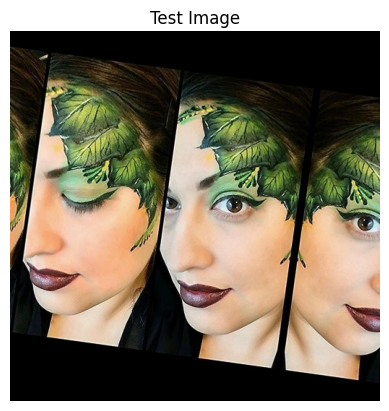


FINAL PREDICTION RESULT:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Person is wearing covered


In [17]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

IMAGE_FOR_FINAL_TEST = "/content/face-attributes-grouped/face-attributes-grouped/test/facewear/covered/605952bad1bf1020cb7b515f48798a71--facepaint-ideas-halloween-face.jpg"

# Display image
img = mpimg.imread(IMAGE_FOR_FINAL_TEST)
plt.imshow(img)
plt.axis('off')
plt.title("Test Image")
plt.show()

# Prediction
print("\nFINAL PREDICTION RESULT:")
print(predict_accessories(IMAGE_FOR_FINAL_TEST))


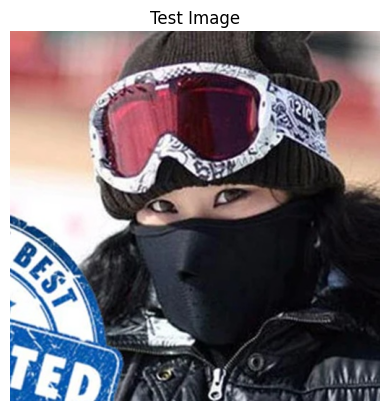


FINAL PREDICTION RESULT:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Person is wearing fullmask


In [18]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

IMAGE_FOR_FINAL_TEST ="/content/face-attributes-grouped/face-attributes-grouped/test/facewear/fullmask/1_432b0f16-6354-48e4-a83c-f5a8fb1ee32d_580x.jpg"

# Display image
img = mpimg.imread(IMAGE_FOR_FINAL_TEST)
plt.imshow(img)
plt.axis('off')
plt.title("Test Image")
plt.show()

# Prediction
print("\nFINAL PREDICTION RESULT:")
print(predict_accessories(IMAGE_FOR_FINAL_TEST))


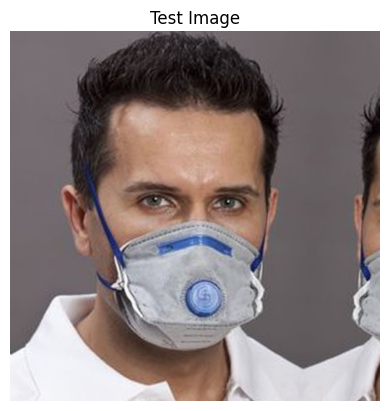


FINAL PREDICTION RESULT:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Person is wearing mouthmask


In [19]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

IMAGE_FOR_FINAL_TEST ="/content/face-attributes-grouped/face-attributes-grouped/test/facewear/mouthmask/36021-7172591.jpg"
# Display image
img = mpimg.imread(IMAGE_FOR_FINAL_TEST)
plt.imshow(img)
plt.axis('off')
plt.title("Test Image")
plt.show()

# Prediction
print("\nFINAL PREDICTION RESULT:")
print(predict_accessories(IMAGE_FOR_FINAL_TEST))


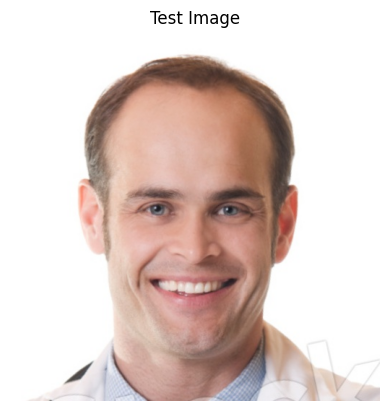


FINAL PREDICTION RESULT:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Person is wearing no_facewear


In [20]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

IMAGE_FOR_FINAL_TEST ="/content/face-attributes-grouped/face-attributes-grouped/test/facewear/no_facewear/19167116-male-vet-in-lab-coat-with-cat.jpg"
# Display image
img = mpimg.imread(IMAGE_FOR_FINAL_TEST)
plt.imshow(img)
plt.axis('off')
plt.title("Test Image")
plt.show()

# Prediction
print("\nFINAL PREDICTION RESULT:")
print(predict_accessories(IMAGE_FOR_FINAL_TEST))
